# Regression Used Cars Dataset

https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data 


#### **Dependency**

In [1]:
#! pip install lightgbm

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import combinations  # For creating combinations of elements
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import lightgbm as lgb 
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn import preprocessing

#### **Utility Function**

In [2]:
def reduce_mem_usage(df, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    # Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # 🔄 Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype
        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    # ℹ️ Provide memory optimization information if 'verbose' is True
    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")

    # Return the DataFrame with optimized memory usage
    return df

#### **Load Data**

load csv inside data folder

In [3]:
df = pd.read_csv("./data/vehicles.csv")
df=reduce_mem_usage(df,verbose=True)
df.shape
df[0:4]

Memory usage of dataframe is 84.68 MB
Memory usage after optimization is: 76.54 MB
Decreased by 9.62%


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN


#### **Split dataset** 

In [4]:
df_train, df_test = train_test_split(df, test_size=0.2)
print(df_train.shape, df_test.shape)

(341504, 26) (85376, 26)


#### **Data Function**

data preperation

feature engineering

In [5]:
def data_preparation(df:pd.DataFrame)->pd.DataFrame:
    """"
    make data valid
    """
    #Create df1, get the average value of deleting NAN and outliers, then assign it to the NAN in df, 
    #and then delete the outliers in df to get the latest data set
    df1 = df.copy()
    odometer_data = df1['odometer']
    odometer_data_cleaned = odometer_data.dropna()
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(odometer_data_cleaned.values.reshape(-1, 1))

    outliers = odometer_data_cleaned[kmeans.labels_ == 1]
    df1 = df1[~df1['odometer'].isin(outliers)]
    average_value = df1['odometer'].mean()
    df['odometer'] = df['odometer'].fillna(average_value)
    
    #Use Kmeans to calculate outliers and delete them together with data with a price less than 1,000
    #($1,000 is about ￥7,500. Even the price of a second-hand car is too low, so it is also regarded as an outlier and deleted)
    price_data = df['price']
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(price_data.values.reshape(-1, 1))
    outliers = price_data[kmeans.labels_ == 1]

    df = df[~((price_data.isin(outliers)) | (price_data < 1000))]
    
    #use linear regression to prediect values for null in year col.
    features = ["price",'odometer']
    df_complete = df.dropna(subset=["year"] + features)
    X_train = df_complete[features]
    y_train = df_complete["year"]
    regression_model_year = LinearRegression()
    regression_model_year.fit(X_train, y_train)
    X_missing = df[df["year"].isnull()][features]
    predicted_year = regression_model_year.predict(X_missing)

    df.loc[df["year"].isnull(), "year"] = predicted_year.round().astype(int)
    
    #Fill null values using the modes of "manufacturer", "cylinders", 'fuel',"title_status", "transmission","drive", "type", "paint_color", "lat", "long"
    columns_to_fillna = ['manufacturer', 'cylinders', 'fuel', 'title_status', 'transmission',
                     'drive', 'type', 'paint_color', 'lat', 'long','posting_date']
    modes = df[columns_to_fillna].mode().iloc[0]
    df.loc[:, columns_to_fillna] = df.loc[:, columns_to_fillna].fillna(value=modes)
    
    #for "condition" col: Fill NAN with randomly selected data from that column to manipulate the more possible results.
    # Calculate the probability of each value (excluding NaN)
    condition_options = df["condition"].unique()
    df.loc[df["condition"].isnull(), "condition"] = np.random.choice(condition_options)

    # turn nominal data into number
    y = df['price']
    x =df.drop(columns=['price'])


    return x,y

def feature_engineering(df:pd.DataFrame)->pd.DataFrame:
    """"
    select useful feature
    """
    #vehicle_age=posting_year - year, get the usage time of this vehicle
    df["posting_date"] = pd.to_datetime(df["posting_date"], utc=True)
    df["posting_year"] = df["posting_date"].dt.year
    df["vehicle_age"] = df["posting_year"] - df["year"]
    
    #Remove meaningless columns
    df.drop(['id','url','region','region_url','model','title_status',
         'image_url','VIN','size','county','description',
         'state','lat','long','posting_date','posting_year'], 
        axis=1, inplace=True)
    
    return df

def encoding(df:pd.DataFrame,encoders=None)->pd.DataFrame:
    cols = df.columns.values.tolist()
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    categorical_cols = []
    for col in cols:
        if df[col].dtype in numerics: continue
        categorical_cols.append(col)

    if(encoders==None):
        encoders=[]
        for col in categorical_cols:
            le = preprocessing.LabelEncoder()
            le.fit(list(df[col].astype(str).values))
            df[col] = le.transform(list(df[col].astype(str).values))
            encoders.append(le)
    else:
        id=0
        for col in categorical_cols:
            le = encoders[id]
            df[col] = le.transform(list(df[col].astype(str).values))
            id=id+1

    return df,encoders





def data_preprocessing(df:pd.DataFrame ,datasetType="train", labelEncoders=None)->pd.DataFrame:
    x , y =data_preparation(df)
    x=feature_engineering(x)
    encoders=labelEncoders
    if(datasetType=="train"):
        x,encoders=encoding(x,encoders=encoders)
    if(datasetType=="test"):
        if(encoders==None):
            print("Please give a encoder")
            raise RuntimeError
        x,_ = encoding(x,encoders)
    return x,y,encoders



In [6]:
df_train_x,df_train_y,encoders = data_preprocessing(df_train,datasetType="train")
df_test_x, df_test_y,_ = data_preprocessing(df_test,datasetType="test",labelEncoders=encoders)
print(df_train_x.isna().sum())
print(df['type'].unique())
print(df_train_x.shape, df_train_y.shape)

d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  s

year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
type            0
paint_color     0
vehicle_age     0
dtype: int64
[nan 'pickup' 'truck' 'other' 'coupe' 'SUV' 'hatchback' 'mini-van' 'sedan'
 'offroad' 'bus' 'van' 'convertible' 'wagon']
(304375, 11) (304375,)


In [7]:
df_train_x[0:4]

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,vehicle_age
196596,2021.0,5,0,5,2,2189.0,0,1,0,0,0.0
97138,2008.0,13,4,5,2,163231.0,0,1,0,10,13.0
21699,2018.0,7,0,5,2,22177.0,0,2,9,9,3.0
368631,2014.0,34,0,5,2,116353.0,0,0,8,10,7.0


In [8]:
df_test_x[0:4]

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,vehicle_age
240775,2010.0,7,0,6,2,88551.0,0,0,10,10,11.0
232999,2005.0,17,0,5,2,123000.0,0,1,9,10,16.0
326464,2013.0,39,0,5,2,93942.0,0,1,9,9,8.0
36874,2019.0,7,0,5,2,32135.0,0,1,9,0,2.0


#### **Training and Evaluation**

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 546
[LightGBM] [Info] Number of data points in the train set: 304375, number of used features: 11
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 8 dense feature groups (2.32 MB) transferred to GPU in 0.005855 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 15990.000000
Root Mean Squared Error: 451292.3730401762
Mean Absolute Error: 9203.059130164507
R-squared: 0.0003230109064127351


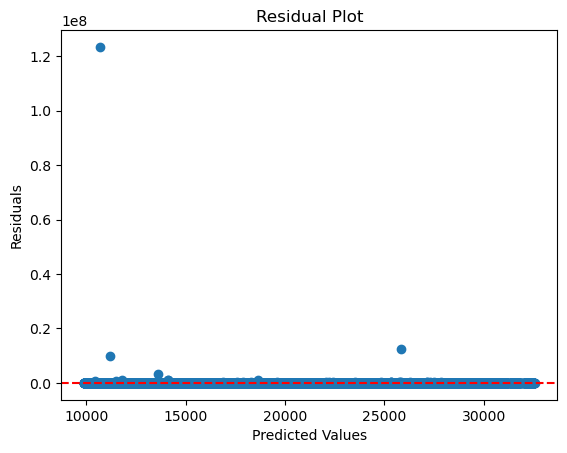

In [9]:
# training
numJobs=3
cv=5
paramgrid={
                "objective": ["mae"],
                "n_estimators": [500,750],
                "num_leaves": [256],
                "subsample": [1],
                "colsample_bytree":[0.6],
                "learning_rate": [0.001],
            }

model = lgb.LGBMRegressor(n_estimators= 500,random_state=4487,objective='mae',learning_rate=0.05,importance_type= "gain",device="gpu")
modelCV= GridSearchCV(model,param_grid=paramgrid,n_jobs=numJobs,verbose=True,cv=cv)
modelCV.fit(df_train_x, df_train_y)

#predict
y_pred = modelCV.predict(df_test_x)

#evaluation

# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()